In [51]:
%matplotlib inline
import matplotlib.pyplot as plt


In [52]:
import pandas as pd 
import numpy as np
import calendar

from datetime import datetime, date, timedelta
from math import sqrt


In [53]:
#Pull latest data from binance 

import ccxt
exchange_class = getattr(ccxt, 'binance')
binance  = exchange_class()


def min_ohlcv(dt, pair, limit):
    # UTC native object
    since = calendar.timegm(dt.utctimetuple())*1000
    ohlcv1 = binance.fetch_ohlcv(symbol=pair, timeframe='1m', since=since, limit=limit)
    ohlcv2 = binance.fetch_ohlcv(symbol=pair, timeframe='1m', since=since, limit=limit)
    ohlcv = ohlcv1 + ohlcv2
    return ohlcv

def ohlcv(dt, pair, period='1d'):
    ohlcv = []
    limit = 1000
    if period == '1m':
        limit = 720
    elif period == '1d':
        limit = 365
    elif period == '1h':
        limit = 24
    elif period == '5m':
        limit = 288
    for i in dt:
        start_dt = datetime.strptime(i, "%Y%m%d")
        since = calendar.timegm(start_dt.utctimetuple())*1000
        if period == '1m':
            ohlcv.extend(min_ohlcv(start_dt, pair, limit))
        else:
            ohlcv.extend(binance.fetch_ohlcv(symbol=pair, timeframe=period, since=since, limit=limit))
    df = pd.DataFrame(ohlcv, columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Time'] = [datetime.fromtimestamp(float(time)/1000) for time in df['Time']]
    df['Open'] = df['Open'].astype(np.float64)
    df['High'] = df['High'].astype(np.float64)
    df['Low'] = df['Low'].astype(np.float64)
    df['Close'] = df['Close'].astype(np.float64)
    df['Volume'] = df['Volume'].astype(np.float64)
    df.set_index('Time', inplace=True)
    return df

from datetime import datetime, date, timedelta

start_day = "20210101" #"20201201"
start_dt = datetime.strptime(start_day, "%Y%m%d")
end_day = "20220630"
end_dt = datetime.strptime(end_day, "%Y%m%d")
days_num = (end_dt - start_dt).days + 1
datelist = [start_dt + timedelta(days=x) for x in range(days_num)]
datelist = [date.strftime("%Y%m%d") for date in datelist]

#fwd = 10
coin = 'ETH'
pair = coin + "/USDT"
df = ohlcv(datelist, pair, '1m')

df.to_csv("prices_all_1m.csv")

In [54]:
# calculations for Perp V2 LP 

def calculateL(pNow, pDeposit, vDeposit ,pLower, pUpper) : 
    if pDeposit < pLower : 
        L = vDeposit / (pDeposit * ( 1 / sqrt(pLower) - 1 / sqrt(pUpper)))
    elif pDeposit > pUpper :
        L = vDeposit / (sqrt(pUpper) - sqrt(pLower) )
    else : 
        L = vDeposit / (pDeposit*(1 / sqrt(pDeposit) - 1 / sqrt(pUpper) ) + sqrt(pDeposit) - sqrt(pLower) )

    return L 

def getYLower(pLower, pUpper, L) :
    return L * sqrt(pLower)

def getXUpper(pLower, pUpper, L) :
    return L / sqrt(pUpper) 
    
def getYMax(pLower, pUpper, L) :
    return (sqrt(pUpper) - sqrt(pLower)) * L 
    
def getXMax(pLower, pUpper, L) : 
    return (1 / sqrt(pLower) - 1 / sqrt(pUpper)) * L 
    
def getXReal(pCurrent, pLower, pUpper, L) : 
    if pCurrent < pLower : 
        X = getXMax(pLower, pUpper, L)
    elif pCurrent > pUpper :
        X = 0
    else : 
        X = (L / sqrt(pCurrent)) - getXUpper(pLower, pUpper, L)
    return X 
    
def getYReal(pCurrent, pLower, pUpper, L) : 
    if pCurrent < pLower : 
        Y = 0
    elif pCurrent > pUpper :
        Y = getYMax(pLower, pUpper, L)
    else : 
        Y = (L * sqrt(pCurrent)) - getYLower(pLower, pUpper, L)

    return Y     
    
def getXLP(pCurrent, pLower, pUpper, L) : 
    return (getXReal(pCurrent, pLower, pUpper, L) * pCurrent)

def getYLP(pCurrent, pLower, pUpper, L) : 
    return (getYReal(pCurrent, pLower, pUpper, L))
    
def getVLP(pCurrent, pLower, pUpper, L) : 
    x = getXLP(pCurrent, pLower, pUpper, L)
    y = getYLP(pCurrent, pLower, pUpper, L)
    return (x + y)



In [55]:
# Strategy paramaters 

lendAllocation = .65
#debt thresholds for rebalancing
debtLow = .975
debtHigh = 1.025
collatLow = .5
collatTarget = .55
collatHigh = .6
slippageAdj = 0.001 #.005 #when rebalancing losses from swapping 

# APY's
lendRate = .0
borrowRate = .0
lpRewards = 2

#SIM INFO
stepsPerYear = 365*24*60 #if simulating hourly set to be 365 * 24 

annualRates = {'lend' : lendRate, 'borrow' : borrowRate, 'lp' : lpRewards}
adjRates = {'lend' : (lendRate/stepsPerYear), 
            'borrow' : (borrowRate/stepsPerYear),
            'lp' : (lpRewards/stepsPerYear)}

# lpRange 
lowRange = 0.5
highRange = 2


In [56]:
# Strategy functions for simulations 

def doRebalance(cRatio, debtRatio) : 
    if cRatio < collatLow : doRebalance = True
    elif cRatio > collatHigh : doRebalance = True
    elif debtRatio < debtLow : doRebalance = True
    elif debtRatio > debtHigh : doRebalance = True
    else : doRebalance = False
    
    return doRebalance


def enterPosition(pNow, depositAmount):
    Collateral = lendAllocation*depositAmount
    Debt = (1 - lendAllocation)*depositAmount
    lpAmount = Debt*2
    DebtX = Debt / pNow
    lpAmount = Debt*2 # we pair equally     
    PLow = lowRange * pNow
    PHigh = highRange * pNow
    PEntry = pNow 
    L = calculateL(pNow, pNow, lpAmount ,PLow, PHigh)
    return (PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount)

def updatePosition(p, Collateral, DebtX):

    Collateral = Collateral*(1+adjRates['lend'])
    DebtX = DebtX *(1+adjRates['borrow'])
    Debt = DebtX * p
    return Collateral, DebtX, Debt

#def exitPosition

In [57]:
from scipy.stats import sem
nLags = 60*6 
semData = []

for j in range(len(df) - nLags) : 
    endInd = j + nLags
    semData.append(sem(df['Close'][j : endInd] / df['Close'][j : endInd].mean()))
                


In [58]:
percentile = 90
pauseMax = np.percentile(semData, percentile)


In [59]:
# Simulate based on historical market data 
### No Pausing 

PStart = df['Open'].iloc[nLags+1]
depositAmount = 1000000
PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(PStart, depositAmount)

maxPortfolio = depositAmount 
minPortfolio = depositAmount

harvestFrequency = 360 
harvestCounter = 0 

portfolioTrack = []
trackFreq = 60*24*30

for i in range(len(df) - nLags - 1) : 
        p = df['Close'].iloc[i + nLags + 1]
        harvestCounter += 1 
        #p = PEntry 
        Collateral, DebtX, Debt = updatePosition(p, Collateral, DebtX)
        
        #Debt = DebtX * p
        L = calculateL(p, PEntry, lpAmount ,PLow, PHigh)        
        # add LP rewards
        L = L *(1+adjRates['lp'])

        # Key Metrics for rebalancing 
        
        CRatio = Debt / Collateral 
        xInLp = getXReal(p, PLow, PHigh, L)
        DebtRatio = xInLp / DebtX
        
        # rebalance LOGIC HERHEHEHREHERHEEH
        rebalance = doRebalance(CRatio, DebtRatio)
        if rebalance == True :
            #print("Rebalance ---- ")
            #print("C Ratio : "  + str(int(CRatio*100)))
            #print("Debt Ratio : "  + str(int(DebtRatio*100)))

            lpValue = getVLP(p, PLow, PHigh, L)
            if DebtRatio < 1 : 
                slippage = (DebtX - xInLp)*p*slippageAdj
            else : 
                slippage = (xInLp - DebtX)*p*slippageAdj
            portFolio = Collateral - Debt + lpValue - slippage 
            
            # we re-enter position with new range 
            PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(p, portFolio)
            
        lpValue = getVLP(p, PLow, PHigh, L)
        # PRINT SOME FREE MONEY REEEEEEE
        if harvestCounter > harvestFrequency :
            
            Collateral = Collateral + (lpValue*adjRates['lp']*harvestCounter)
            harvestCounter = 0 
            
        portFolio = Collateral - Debt + lpValue

        maxPortfolio = max(maxPortfolio, portFolio)
        minPortfolio = min(minPortfolio, portFolio)
    
        if i % trackFreq == 0 : 
            print("Iteration Number --- " + str(i))
            print("Price "  + str(int(p)))
            print("Portfolio Value --- " + str(int(portFolio)))
            portfolioTrack.append(portFolio)
            print(" --- " )


Iteration Number --- 0
Price 742
Portfolio Value --- 1000002
 --- 
Iteration Number --- 43200
Price 1346
Portfolio Value --- 971442
 --- 
Iteration Number --- 86400
Price 1553
Portfolio Value --- 1009735
 --- 
Iteration Number --- 129600
Price 1915
Portfolio Value --- 1091619
 --- 
Iteration Number --- 172800
Price 2847
Portfolio Value --- 1149378
 --- 
Iteration Number --- 216000
Price 2331
Portfolio Value --- 1095662
 --- 
Iteration Number --- 259200
Price 2122
Portfolio Value --- 1156788
 --- 
Iteration Number --- 302400
Price 2402
Portfolio Value --- 1245752
 --- 
Iteration Number --- 345600
Price 3185
Portfolio Value --- 1352843
 --- 
Iteration Number --- 388800
Price 2944
Portfolio Value --- 1441385
 --- 
Iteration Number --- 432000
Price 3999
Portfolio Value --- 1570851
 --- 
Iteration Number --- 475200
Price 4096
Portfolio Value --- 1717956
 --- 
Iteration Number --- 518400
Price 4062
Portfolio Value --- 1860828
 --- 
Iteration Number --- 561600
Price 2479
Portfolio Value --- 2

In [60]:
# Simulate based on historical market data 
### With Pausing 

PStart = df['Open'].iloc[nLags+1]
depositAmount = 1000000
PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(PStart, depositAmount)

maxPortfolio = depositAmount 
minPortfolio = depositAmount

harvestFrequency = 360 
harvestCounter = 0 

portfolioTrack1 = []
trackFreq = 60*24*30

paused = False 

for i in range(len(df) - nLags - 1) : 
        p = df['Close'].iloc[i + nLags + 1]
        harvestCounter += 1 
        #p = PEntry 
        Collateral, DebtX, Debt = updatePosition(p, Collateral, DebtX)
        
        #Debt = DebtX * p
        L = calculateL(p, PEntry, lpAmount ,PLow, PHigh)        
        # add LP rewards
        L = L *(1+adjRates['lp'])

        # Key Metrics for rebalancing 
        
        CRatio = Debt / Collateral 
        xInLp = getXReal(p, PLow, PHigh, L)
        DebtRatio = xInLp / DebtX
        
        # rebalance LOGIC HERHEHEHREHERHEEH
        rebalance = doRebalance(CRatio, DebtRatio)
        if rebalance == True :
            #print("Rebalance ---- ")
            #print("C Ratio : "  + str(int(CRatio*100)))
            #print("Debt Ratio : "  + str(int(DebtRatio*100)))
            if paused == False : 

                lpValue = getVLP(p, PLow, PHigh, L)
                if DebtRatio < 1 : 
                    slippage = (DebtX - xInLp)*p*slippageAdj
                else : 
                    slippage = (xInLp - DebtX)*p*slippageAdj
                portFolio = Collateral - Debt + lpValue - slippage 

                # we re-enter position with new range 
                PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(p, portFolio)

        lpValue = getVLP(p, PLow, PHigh, L)
        # PRINT SOME FREE MONEY REEEEEEE
        if harvestCounter > harvestFrequency :
            
            Collateral = Collateral + (lpValue*adjRates['lp']*harvestCounter)
            harvestCounter = 0 
            
        portFolio = Collateral - Debt + lpValue
        
        ### Pause / Unpause 
        
        se = semData[i]
        if se > pauseMax : 
            if paused == False : 
                paused = True 
                if DebtRatio < 1 : 
                    slippage = (DebtX - xInLp)*p*slippageAdj
                else : 
                    slippage = (xInLp - DebtX)*p*slippageAdj
                portFolio = Collateral - Debt + lpValue - slippage 
                Collateral = portFolio
                DebtX = 0
                L = 0
                lpAmount = 0 
            
            
        if se < pauseMax : 
            if paused == True :
                paused = False 
                PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(p, portFolio)

        
        
        maxPortfolio = max(maxPortfolio, portFolio)
        minPortfolio = min(minPortfolio, portFolio)
    
        if i % trackFreq == 0 : 
            print("Iteration Number --- " + str(i))
            print("Price "  + str(int(p)))
            print("Portfolio Value --- " + str(int(portFolio)))
            portfolioTrack1.append(portFolio)
            print(" --- " )



Iteration Number --- 0
Price 742
Portfolio Value --- 1000002
 --- 


/tmp/ipykernel_5984/3856164850.py:34: RuntimeWarning: invalid value encountered in double_scalars
  DebtRatio = xInLp / DebtX


Iteration Number --- 43200
Price 1346
Portfolio Value --- 989364
 --- 
Iteration Number --- 86400
Price 1553
Portfolio Value --- 1052173
 --- 
Iteration Number --- 129600
Price 1915
Portfolio Value --- 1118784
 --- 
Iteration Number --- 172800
Price 2847
Portfolio Value --- 1181412
 --- 
Iteration Number --- 216000
Price 2331
Portfolio Value --- 1185318
 --- 
Iteration Number --- 259200
Price 2122
Portfolio Value --- 1254917
 --- 
Iteration Number --- 302400
Price 2402
Portfolio Value --- 1348078
 --- 
Iteration Number --- 345600
Price 3185
Portfolio Value --- 1452561
 --- 
Iteration Number --- 388800
Price 2944
Portfolio Value --- 1576571
 --- 
Iteration Number --- 432000
Price 3999
Portfolio Value --- 1718592
 --- 
Iteration Number --- 475200
Price 4096
Portfolio Value --- 1879791
 --- 
Iteration Number --- 518400
Price 4062
Portfolio Value --- 2040796
 --- 
Iteration Number --- 561600
Price 2479
Portfolio Value --- 2214413
 --- 
Iteration Number --- 604800
Price 2602
Portfolio Value

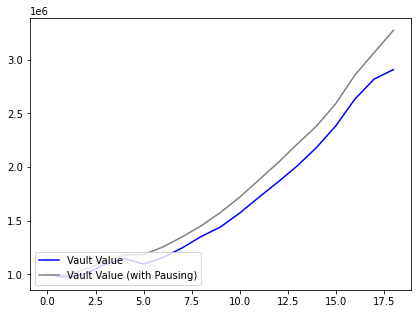

In [61]:
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.plot(portfolioTrack, color = 'blue', label = 'Vault Value' )
ax.plot(portfolioTrack1, color = 'grey', label = 'Vault Value (with Pausing)' )
ax.legend(loc = 'lower left')


plt.show()